Importing the required Libraries


In [ ]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Define paths
base_path = "D:/SoulPageIT"  # Change this to your actual folder path
detection_folder = os.path.join(base_path, "license_plates_detection_train")
recognition_folder = os.path.join(base_path, "license_plates_recognition_train")
detection_csv = os.path.join(base_path, "Licplatesdetection_train.csv")
recognition_csv = os.path.join(base_path, "Licplatesrecognition_train.csv")


In [ ]:
# Load CSV files
df_detection = pd.read_csv(detection_csv)
df_recognition = pd.read_csv(recognition_csv)


In [ ]:
# Display first few rows
print("🔹 Detection CSV:")
print(df_detection.head())

print("\n🔹 Recognition CSV:")
print(df_recognition.head())

🔹 Detection CSV:
    img_id  ymin  xmin  ymax  xmax
0    1.jpg   276    94   326   169
1   10.jpg   311   395   344   444
2  100.jpg   406   263   450   434
3  101.jpg   283   363   315   494
4  102.jpg   139    42   280   222

🔹 Recognition CSV:
    img_id      text
0    0.jpg  117T3989
1    1.jpg  128T8086
2   10.jpg   94T3458
3  100.jpg  133T6719
4  101.jpg   68T5979


In [ ]:
# Check number of images in each folder
print("\n🔹 Number of detection images:", len(os.listdir(detection_folder)))
print("🔹 Number of recognition images:", len(os.listdir(recognition_folder)))


🔹 Number of detection images: 900
🔹 Number of recognition images: 910


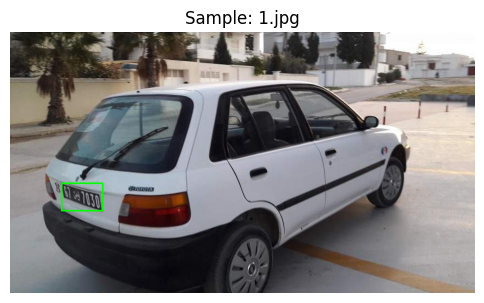

In [ ]:
def visualize_sample(image_name):
    # Load image
    image_path = os.path.join(detection_folder, image_name)
    image = cv2.imread(image_path)

    if image is None:
        print(f"❌ Error: {image_name} not found.")
        return
    
    # Get bounding box from CSV
    bbox = df_detection[df_detection["img_id"] == image_name]
    for _, row in bbox.iterrows():
        xmin, ymin, xmax, ymax = row["xmin"], row["ymin"], row["xmax"], row["ymax"]
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

    # Convert image to RGB (for proper display in matplotlib)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display image
    plt.figure(figsize=(6, 4))
    plt.imshow(image)
    plt.title(f"Sample: {image_name}")
    plt.axis("off")
    plt.show()

# Test visualization
sample_image = df_detection["img_id"].iloc[0]  # First image from CSV
visualize_sample(sample_image)


In [ ]:
import os
import cv2

# Define YOLO label folder
yolo_labels_folder = os.path.join(base_path, "yolo_labels")
os.makedirs(yolo_labels_folder, exist_ok=True)

def convert_to_yolo_format(df, image_folder, label_folder):
    for index, row in df.iterrows():
        image_name = row["img_id"]
        image_path = os.path.join(image_folder, image_name)

        # Read image to get dimensions
        image = cv2.imread(image_path)
        if image is None:
            print(f"❌ Skipping {image_name} (Image not found)")
            continue
        
        img_h, img_w, _ = image.shape

        # Convert bbox to YOLO format
        xmin, ymin, xmax, ymax = row["xmin"], row["ymin"], row["xmax"], row["ymax"]
        x_center = ((xmin + xmax) / 2) / img_w
        y_center = ((ymin + ymax) / 2) / img_h
        width = (xmax - xmin) / img_w
        height = (ymax - ymin) / img_h

        # YOLO class_id (0 for license plate)
        yolo_annotation = f"0 {x_center} {y_center} {width} {height}\n"

        # Save annotation file
        label_file = os.path.join(label_folder, image_name.replace(".jpg", ".txt"))
        with open(label_file, "w") as file:
            file.write(yolo_annotation)

convert_to_yolo_format(df_detection, detection_folder, yolo_labels_folder)
print("✅ YOLO annotations created successfully!")


✅ YOLO annotations created successfully!


In [ ]:
import shutil
from sklearn.model_selection import train_test_split

# Create directories
yolo_dataset_path = os.path.join(base_path, "yolo_dataset")
images_train = os.path.join(yolo_dataset_path, "images/train")
images_val = os.path.join(yolo_dataset_path, "images/val")
labels_train = os.path.join(yolo_dataset_path, "labels/train")
labels_val = os.path.join(yolo_dataset_path, "labels/val")

for folder in [images_train, images_val, labels_train, labels_val]:
    os.makedirs(folder, exist_ok=True)

# Split data into train & val (80-20 split)
image_files = os.listdir(detection_folder)
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Move images & labels
for file in train_files:
    shutil.copy(os.path.join(detection_folder, file), images_train)
    shutil.copy(os.path.join(yolo_labels_folder, file.replace(".jpg", ".txt")), labels_train)

for file in val_files:
    shutil.copy(os.path.join(detection_folder, file), images_val)
    shutil.copy(os.path.join(yolo_labels_folder, file.replace(".jpg", ".txt")), labels_val)

print("✅ Dataset is ready for YOLO training!")


✅ Dataset is ready for YOLO training!


In [14]:
from ultralytics import YOLO

# Load YOLOv8 model
model = YOLO("yolov8n.pt")  # Using YOLOv8 nano for speed

# Train model
model.train(data="D:/SoulPageIT/data.yaml", epochs=50, imgsz=640, batch=16, device="cpu")


Ultralytics 8.3.78  Python-3.12.0 torch-2.6.0+cpu CPU (11th Gen Intel Core(TM) i3-1115G4 3.00GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=D:/SoulPageIT/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tru

train: Scanning D:\SoulPageIT\yolo_dataset\labels\train... 720 images, 0 backgrounds, 0 corrupt: 100%|██████████| 720/720 [00:03<00:00, 222.46it/s]


train: New cache created: D:\SoulPageIT\yolo_dataset\labels\train.cache


val: Scanning D:\SoulPageIT\yolo_dataset\labels\val... 180 images, 0 backgrounds, 0 corrupt: 100%|██████████| 180/180 [00:00<00:00, 220.42it/s]

val: New cache created: D:\SoulPageIT\yolo_dataset\labels\val.cache


Plotting labels to D:\projects\runs\detect\train6\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to D:\projects\runs\detect\train6
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.181       2.32      1.076         36        640: 100%|██████████| 45/45 [06:09<00:00,  8.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:28<00:00,  4.75s/it]

                   all        180        180          1     0.0241      0.881      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.197      1.469       1.04         17        640: 100%|██████████| 45/45 [06:06<00:00,  8.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.49s/it]

                   all        180        180      0.939      0.942      0.977      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.172      1.228      1.025         25        640: 100%|██████████| 45/45 [06:10<00:00,  8.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:28<00:00,  4.83s/it]

                   all        180        180      0.922      0.878      0.927      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.134       1.09      1.026         28        640: 100%|██████████| 45/45 [06:13<00:00,  8.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.57s/it]

                   all        180        180      0.974      0.933      0.981      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.137     0.9492      1.024         33        640: 100%|██████████| 45/45 [06:23<00:00,  8.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.44s/it]

                   all        180        180      0.916      0.961      0.964      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.119     0.8778       1.01         29        640: 100%|██████████| 45/45 [06:11<00:00,  8.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.46s/it]

                   all        180        180      0.978      0.982      0.994      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G       1.09     0.8055      1.007         30        640: 100%|██████████| 45/45 [06:12<00:00,  8.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.58s/it]

                   all        180        180      0.978       0.95      0.991      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.111     0.7798       1.01         24        640: 100%|██████████| 45/45 [06:15<00:00,  8.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.51s/it]

                   all        180        180      0.957      0.989       0.99      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G       1.03     0.7199     0.9855         33        640: 100%|██████████| 45/45 [06:15<00:00,  8.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.47s/it]

                   all        180        180      0.989      0.955      0.993      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G          1     0.7071     0.9883         28        640: 100%|██████████| 45/45 [06:13<00:00,  8.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.46s/it]

                   all        180        180      0.949      0.983      0.985      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.024     0.6906     0.9844         22        640: 100%|██████████| 45/45 [06:10<00:00,  8.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.57s/it]

                   all        180        180      0.958      0.967      0.989      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.011     0.6725     0.9791         29        640: 100%|██████████| 45/45 [06:11<00:00,  8.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.45s/it]

                   all        180        180      0.974      0.989      0.994      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.009     0.6303     0.9673         32        640: 100%|██████████| 45/45 [06:13<00:00,  8.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.42s/it]

                   all        180        180      0.972      0.972      0.993      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G     0.9928     0.6187     0.9665         23        640: 100%|██████████| 45/45 [06:14<00:00,  8.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.50s/it]

                   all        180        180      0.957      0.983      0.991      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      0.971     0.6027      0.964         33        640: 100%|██████████| 45/45 [06:08<00:00,  8.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.45s/it]

                   all        180        180      0.974      0.989      0.994      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G     0.9612     0.5978     0.9637         23        640: 100%|██████████| 45/45 [06:08<00:00,  8.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.49s/it]

                   all        180        180      0.994      0.994      0.995      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      0.987     0.5989     0.9649         32        640: 100%|██████████| 45/45 [06:11<00:00,  8.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:28<00:00,  4.68s/it]

                   all        180        180      0.994      0.993      0.995      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G     0.9641     0.5802      0.948         26        640: 100%|██████████| 45/45 [06:07<00:00,  8.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.56s/it]

                   all        180        180      0.983      0.989      0.993      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G     0.9377     0.5431     0.9436         31        640: 100%|██████████| 45/45 [06:07<00:00,  8.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.46s/it]

                   all        180        180      0.993      0.994      0.995       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G     0.9483      0.558     0.9516         28        640: 100%|██████████| 45/45 [06:06<00:00,  8.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.48s/it]

                   all        180        180          1      0.983      0.995      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G     0.8928     0.5276     0.9339         27        640: 100%|██████████| 45/45 [06:10<00:00,  8.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.41s/it]

                   all        180        180      0.987          1      0.995      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G     0.9677     0.5511     0.9455         29        640: 100%|██████████| 45/45 [06:06<00:00,  8.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:25<00:00,  4.25s/it]

                   all        180        180      0.978      0.996      0.994      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G     0.9479     0.5402      0.953         29        640: 100%|██████████| 45/45 [06:09<00:00,  8.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:25<00:00,  4.31s/it]

                   all        180        180      0.987      0.989      0.994      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G     0.8818     0.5076      0.925         25        640: 100%|██████████| 45/45 [06:39<00:00,  8.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.55s/it]

                   all        180        180      0.988      0.994      0.995      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G     0.9271     0.5373      0.948         36        640: 100%|██████████| 45/45 [06:07<00:00,  8.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.48s/it]

                   all        180        180      0.994      0.999      0.993      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G     0.9019     0.5191     0.9385         35        640: 100%|██████████| 45/45 [06:04<00:00,  8.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:25<00:00,  4.32s/it]

                   all        180        180      0.994          1      0.995       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G     0.8804     0.5051     0.9301         30        640: 100%|██████████| 45/45 [06:08<00:00,  8.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.49s/it]

                   all        180        180      0.992          1      0.995      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G     0.8848     0.5057     0.9343         29        640: 100%|██████████| 45/45 [06:08<00:00,  8.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.53s/it]

                   all        180        180      0.984      0.998      0.995      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G     0.8711     0.4922      0.931         31        640: 100%|██████████| 45/45 [06:04<00:00,  8.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:25<00:00,  4.22s/it]

                   all        180        180      0.973      0.999      0.994      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G     0.8809     0.4916      0.933         26        640: 100%|██████████| 45/45 [06:08<00:00,  8.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.49s/it]

                   all        180        180      0.999          1      0.995      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      0.854     0.4872     0.9255         23        640: 100%|██████████| 45/45 [06:04<00:00,  8.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:25<00:00,  4.26s/it]

                   all        180        180      0.994          1      0.995      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G     0.8637     0.4748     0.9221         24        640: 100%|██████████| 45/45 [06:07<00:00,  8.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:29<00:00,  4.89s/it]

                   all        180        180          1          1      0.995      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G     0.8387     0.4635     0.9187         29        640: 100%|██████████| 45/45 [06:13<00:00,  8.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.61s/it]

                   all        180        180      0.992          1      0.995      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G     0.8375     0.4574      0.916         27        640: 100%|██████████| 45/45 [06:26<00:00,  8.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.51s/it]

                   all        180        180      0.999          1      0.995      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G     0.8118     0.4362     0.9057         32        640: 100%|██████████| 45/45 [06:11<00:00,  8.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.44s/it]

                   all        180        180          1          1      0.995      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G     0.8107     0.4584     0.9062         36        640: 100%|██████████| 45/45 [06:08<00:00,  8.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.43s/it]

                   all        180        180      0.999          1      0.995      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G     0.8107     0.4511     0.9106         40        640: 100%|██████████| 45/45 [06:05<00:00,  8.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.48s/it]

                   all        180        180      0.999          1      0.995      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G     0.8186     0.4493     0.9069         33        640: 100%|██████████| 45/45 [06:08<00:00,  8.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.39s/it]

                   all        180        180          1          1      0.995      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G     0.7883     0.4245     0.9009         29        640: 100%|██████████| 45/45 [06:11<00:00,  8.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.57s/it]

                   all        180        180          1          1      0.995      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G     0.7959     0.4235     0.9035         28        640: 100%|██████████| 45/45 [06:10<00:00,  8.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.50s/it]

                   all        180        180      0.999          1      0.995      0.805


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G     0.7522     0.4013     0.8858         16        640: 100%|██████████| 45/45 [06:09<00:00,  8.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.65s/it]

                   all        180        180      0.994          1      0.995      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G     0.7266     0.3838     0.8756         16        640: 100%|██████████| 45/45 [06:08<00:00,  8.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.44s/it]

                   all        180        180      0.994          1      0.995       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G     0.7174      0.378     0.8828         16        640: 100%|██████████| 45/45 [06:10<00:00,  8.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.50s/it]

                   all        180        180      0.998          1      0.995      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G     0.7085     0.3775      0.885         16        640: 100%|██████████| 45/45 [06:09<00:00,  8.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.48s/it]

                   all        180        180      0.997          1      0.995      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.7037     0.3695     0.8807         16        640: 100%|██████████| 45/45 [06:07<00:00,  8.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.52s/it]

                   all        180        180      0.999          1      0.995      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.6874     0.3627     0.8605         16        640: 100%|██████████| 45/45 [06:09<00:00,  8.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:29<00:00,  4.85s/it]

                   all        180        180      0.999          1      0.995      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.6769     0.3617     0.8707         16        640: 100%|██████████| 45/45 [06:13<00:00,  8.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.54s/it]

                   all        180        180      0.999          1      0.995      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.6675     0.3464     0.8628         16        640: 100%|██████████| 45/45 [06:14<00:00,  8.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:26<00:00,  4.47s/it]

                   all        180        180      0.999          1      0.995      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.6815     0.3517     0.8581         16        640: 100%|██████████| 45/45 [06:08<00:00,  8.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:27<00:00,  4.53s/it]

                   all        180        180      0.999          1      0.995      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.6428     0.3425     0.8616         16        640: 100%|██████████| 45/45 [06:09<00:00,  8.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:25<00:00,  4.27s/it]

                   all        180        180      0.999          1      0.995      0.818



50 epochs completed in 5.564 hours.
Optimizer stripped from D:\projects\runs\detect\train6\weights\last.pt, 6.2MB
Optimizer stripped from D:\projects\runs\detect\train6\weights\best.pt, 6.2MB

Validating D:\projects\runs\detect\train6\weights\best.pt...
Ultralytics 8.3.78  Python-3.12.0 torch-2.6.0+cpu CPU (11th Gen Intel Core(TM) i3-1115G4 3.00GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:22<00:00,  3.83s/it]


                   all        180        180      0.999          1      0.995      0.829
Speed: 3.0ms preprocess, 114.8ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to D:\projects\runs\detect\train6


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000242255AE420>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [ ]:
from ultralytics import YOLO

# Load the best trained model
model = YOLO("D:/projects/runs/detect/train6/weights/best.pt")

# Run inference (test on a sample image)
results = model("D:/path_to_your_test_image.jpg", save=True, show=True)
